In [18]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import os
import io
import glob
from google.cloud import storage
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [4]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/harshsingh/Documents/Loblaw-case-study/key.json"

In [5]:

client = storage.Client()

bucket_name = 'loblaw-bucket'
bucket = client.get_bucket(bucket_name)

In [ ]:
bucket_name = 'loblaw-bucket'
folder_name = 'processed'  
file_name = 'sales-processed.parquet'  
bucket = client.bucket(bucket_name)




object_path = f'{folder_name}/{file_name}'

blob = bucket.blob(object_path)


buffer = io.BytesIO()
    

blob.download_to_file(buffer)
    

buffer.seek(0)
    

df = pd.read_parquet(buffer)


In [10]:
df.shape

(185687, 14)

In [ ]:
df.head

,order_id,product,quantity,each_price,order_date,purchased_address,year,month,day,total_price,street,city,state,zip
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",2019,4,19,23.90,917 1st St,Dallas,TX,75001
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",2019,4,7,99.99,682 Chestnut St,Boston,MA,02215
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019,4,12,600.00,669 Spruce St,Los Angeles,CA,90001
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019,4,12,11.99,669 Spruce St,Los Angeles,CA,90001
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",2019,4,30,11.99,333 8th St,Los Angeles,CA,90001


In [14]:
# Basic statistics
total_revenue = df['total_price'].sum()
total_orders = df['order_id'].nunique()
total_products = df['product'].nunique()
avg_order_value = total_revenue / total_orders


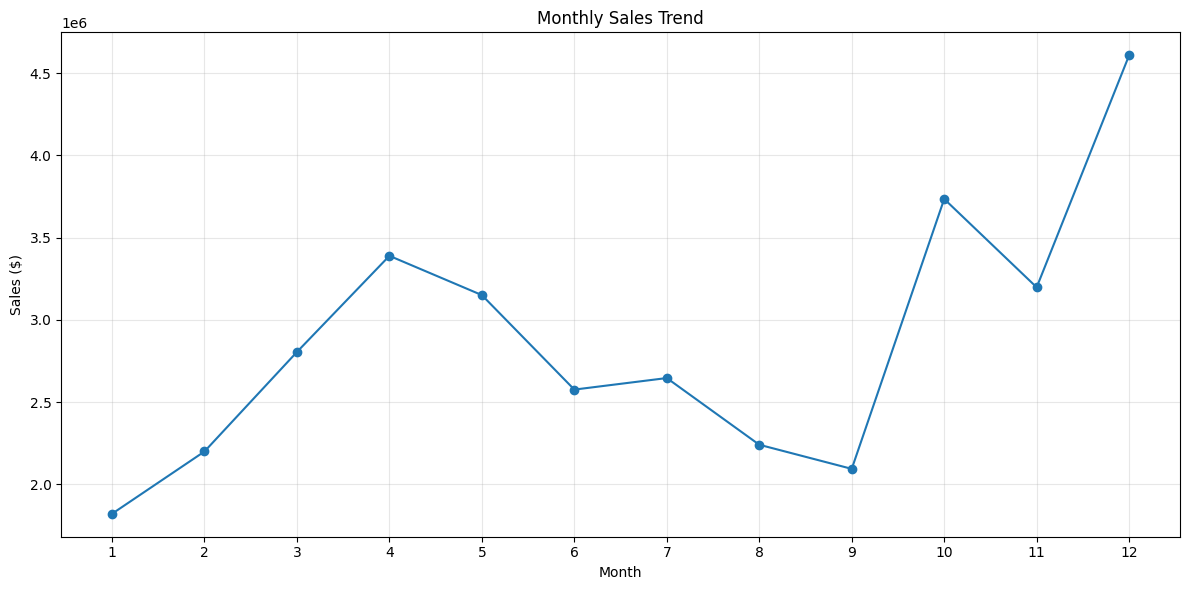

In [ ]:
df['month'] = pd.to_numeric(df['month'], errors='coerce')  # Convert to numeric
df = df[df['month'].between(1, 12)]

monthly_sales = df.groupby('month')['total_price'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['month'], monthly_sales['total_price'], marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.xticks(range(1, 13))  # Ensure only months 1-12 are shown
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'San Francisco'),
  Text(1, 0, 'Los Angeles'),
  Text(2, 0, 'New York City'),
  Text(3, 0, 'Boston'),
  Text(4, 0, 'Atlanta')])

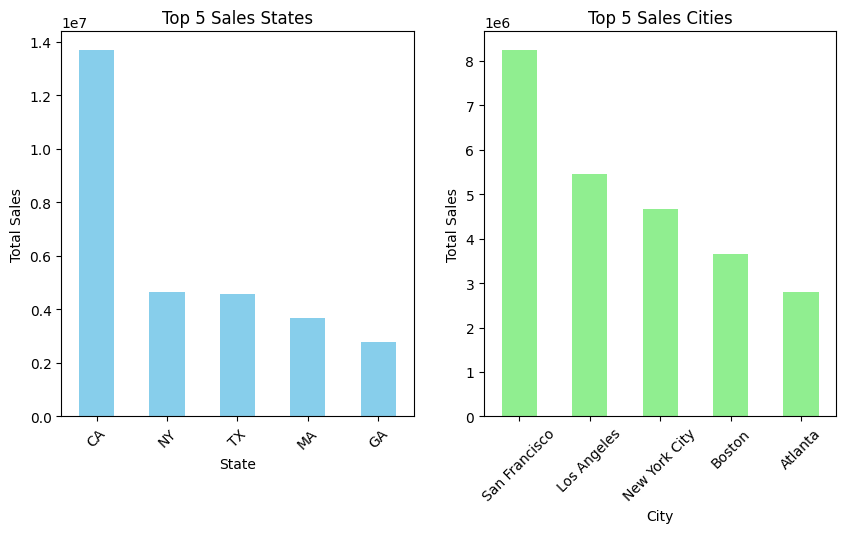

In [46]:

# Group by state and sum the sales
top_states = df.groupby('state')['total_price'].sum().nlargest(5)

# Group by city and sum the sales
top_cities = df.groupby('city')['total_price'].sum().nlargest(5)

# Plotting Top 5 States
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
top_states.plot(kind='bar', color='skyblue')
plt.title('Top 5 Sales States')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# Plotting Top 5 Cities
plt.subplot(1, 2, 2)
top_cities.plot(kind='bar', color='lightgreen')
plt.title('Top 5 Sales Cities')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)


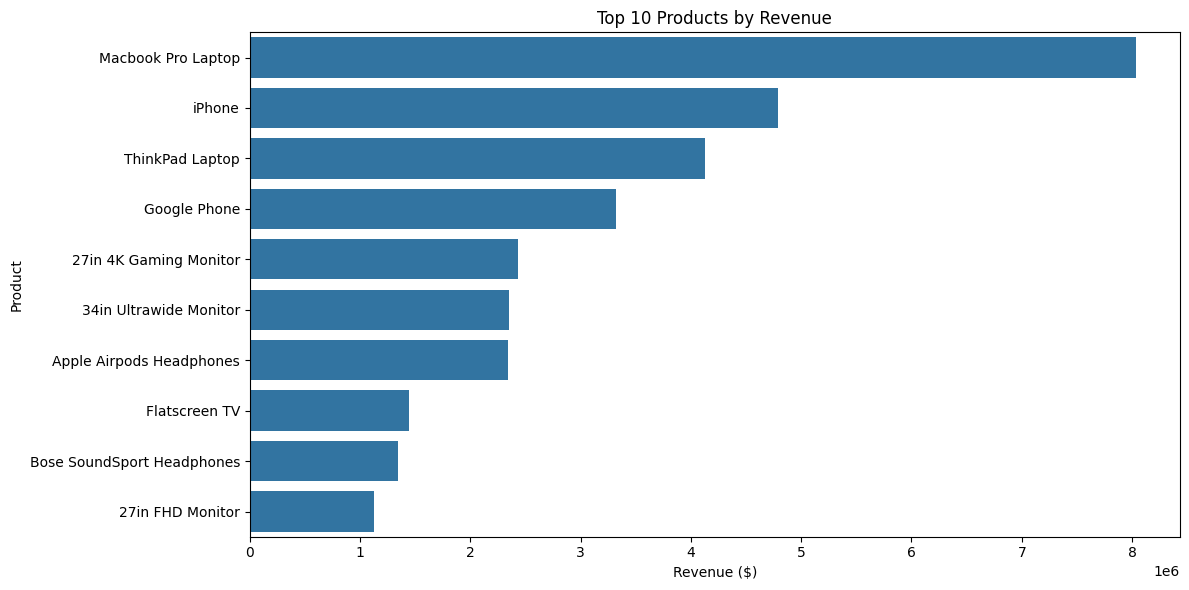

In [22]:

# Top 10 products by revenue
top_products = df.groupby('product').agg(
    total_revenue=('total_price', 'sum'),
    total_quantity=('quantity', 'sum')
).sort_values('total_revenue', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='total_revenue', y=top_products.index, data=top_products.reset_index())
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()



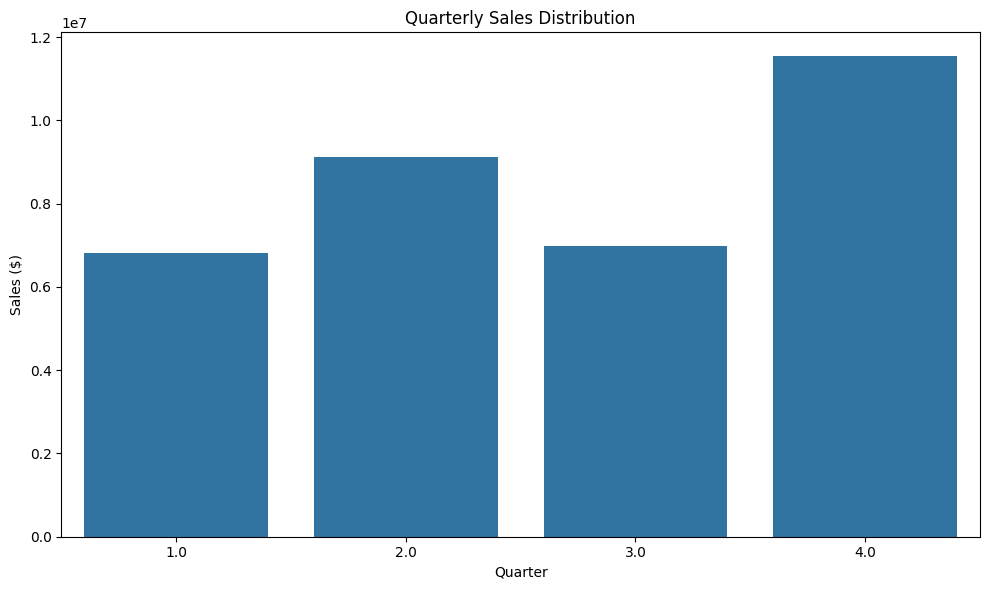

In [ ]:


# Seasonal patterns (quarter-wise analysis)
df['quarter'] = df['order_date'].dt.quarter
quarterly_sales = df.groupby('quarter')['total_price'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='quarter', y='total_price', data=quarterly_sales)
plt.title('Quarterly Sales Distribution')
plt.xlabel('Quarter')
plt.ylabel('Sales ($)')
plt.tight_layout()
plt.show()



In [29]:

# Identify top 5 selling products for ML modeling
top5_products = top_products.head(5).index.tolist()
top5_products


['Macbook Pro Laptop',
 'iPhone',
 'ThinkPad Laptop',
 'Google Phone',
 '27in 4K Gaming Monitor']

In [ ]:
best_month = monthly_sales.loc[monthly_sales['total_price'].idxmax()]['month']
worst_month = monthly_sales.loc[monthly_sales['total_price'].idxmin()]['month']
print(f"Best performing month: {best_month} with ${monthly_sales['total_price'].max():,.2f} in sales")
print(f"Worst performing month: {worst_month} with ${monthly_sales['total_price'].min():,.2f} in sales")

Best performing month: 12.0 with $4,608,295.70 in sales
Worst performing month: 1.0 with $1,821,413.16 in sales


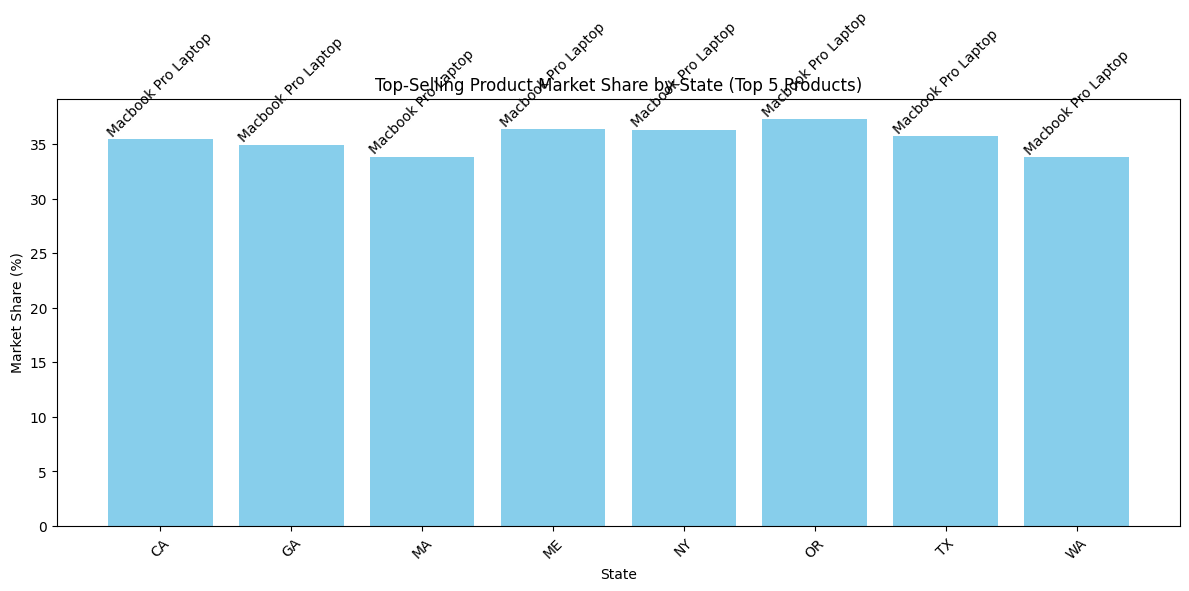

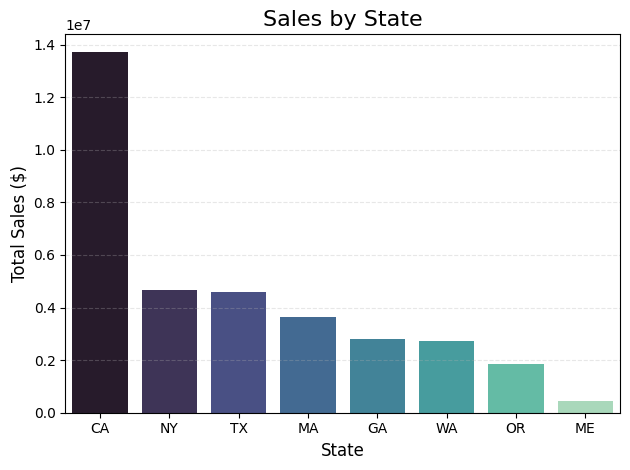

In [ ]:
ax = sns.barplot(x='state', y='total_price', hue='state', data=state_sales, palette='mako', legend=False)
plt.title('Sales by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
plt.close()



In [ ]:
product_mapping = {product: idx+1 for idx, product in enumerate(df['product'].unique())}

# Add the product_id column to the dataframe by mapping the product names
df['product_id'] = df['product'].map(product_mapping)


In [69]:
df.head()

,order_id,product,quantity,each_price,order_date,purchased_address,year,month,day,total_price,street,city,state,zip,quarter,order_size,product_id
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",2019,4,19,23.90,917 1st St,Dallas,TX,75001,2.0,2,1
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",2019,4,7,99.99,682 Chestnut St,Boston,MA,02215,2.0,1,2
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019,4,12,600.00,669 Spruce St,Los Angeles,CA,90001,2.0,1,3
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019,4,12,11.99,669 Spruce St,Los Angeles,CA,90001,2.0,1,4
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",2019,4,30,11.99,333 8th St,Los Angeles,CA,90001,2.0,1,4
